In this notebook, we load what was captured by the SCAMP5 host application when the camera was shown MNIST data. We use this to retrain the fully connected layers, taking noise into account.
 * Parse the .txt file to create numpy training/testing data. It also saved as .pck, for not having to re-parse the file each time.
 * This data is then used to train fully connected layers.

In [0]:
!nvidia-smi

In [0]:
# Partial MNIST by AnalogNet: 100 examples for each digit in each subset (train/test)
#RAW_OUTPUT_FILENAME = 'text_log_20190628_1735_33_reencoded.TXT'

# Whole MNIST capture by AnalogNet
#RAW_OUTPUT_FILENAME = 'text_log_20190702_1750.txt'
#-> 92.6% testing acc with legacy training
#-> 93.8% testing acc with long training
#-> 93.9% testing acc with very long training

# Whole MNIST capture by AnalogNet, with 12 bins instead of 9 (new pooling)
#RAW_OUTPUT_FILENAME = 'text_log_20190714_1101.txt'
# -> 96.4% testing acc with legacy training
# -> 96.8% testing acc with long/very long training

# Whole MNIST capture by AnalogNet, with 12 bins instead of 9, and no
# overlapping between bins
#RAW_OUTPUT_FILENAME = 'text_log_20190718_0030.txt'
# -> 96.3% testing acc with legacy training
# -> 96.7% testing acc with long training
# -> 96.6% testing acc with very long training



# Whole MNIST capture by 3 quantise 3
#RAW_OUTPUT_FILENAME = 'text_log_20190712_2041.txt'
#-> gives 91.9% testing acc with 2 layers, ReLU, very long training...

# Whole MNIST capture by 3 quantise 3, with 150 collected events per feature map
#RAW_OUTPUT_FILENAME = 'text_log_20190714_0030.txt'
#-> gives 92.7% testing acc with 2 layers, long training.
#-> 93.2% testing acc with 2 layers, very long training

# Whole MNIST capture by 3 quantise 3, with 150 collected events per feature map,
# and 12 bins instead of 9 (new pooling)
#RAW_OUTPUT_FILENAME = 'text_log_20190715_0000_38.txt'
# -> 94.6% testing acc with legacy training
# -> 95.7% testing acc with long training
# -> 95.8% testing acc with very long training



# Whole MNIST capture by 4 maxpool 8
#RAW_OUTPUT_FILENAME = 'text_log_20190717_0042.txt'
# -> 91.9% testing acc with legacy training
# -> 92.6% testing acc with long training
# -> 92.9% testing acc with very long training

# Whole MNIST capture by 4 maxpool 8 bis (debugged)
#RAW_OUTPUT_FILENAME = 'text_log_20190731_2346.txt'
# -> % testing acc with legacy training
# -> % testing acc with long training
# -> 92.9% testing acc with very long training


#######################################################################
# Depth separable convolutions, accumulation

# Whole MNIST capture by one layer (similar to AnalogNet, slightly
# different register managmenent)
#RAW_OUTPUT_FILENAME = 'text_log_20190719_0106.txt'
# -> 96.2% testing acc with legacy training
# -> 96.8% testing acc with long training
# -> 96.9% testing acc with very long training

# Whole MNIST capture by two layers of depth separable conv, with leaky ReLU (.25)
#RAW_OUTPUT_FILENAME = 'text_log_20190726_0022.txt'
# -> 93.4% testing acc with legacy training
# -> 94.7% testing acc with long training
# -> 94.4% testing acc with very long training

# Whole MNIST capture by three layers of depth separable conv, with leaky ReLU (.25)
#RAW_OUTPUT_FILENAME = 'text_log_20190727_0013.txt'
# -> 93.3% testing acc with legacy training
# -> 94.1% testing acc with long training
# -> 94.4% testing acc with very long training


# Whole MNIST capture by four layers of depth separable conv, with leaky ReLU (.25)
#RAW_OUTPUT_FILENAME = 'text_log_20190731_0245.txt'
# -> 92.0% testing acc with legacy training
# -> 93.2% testing acc with long training
# -> 93.3% testing acc with very long training





#######################################################################
# One layer network, with increasingly many kernels

# Whole MNIST capture by one layer 1 kernel
#RAW_OUTPUT_FILENAME = 'out13.txt'
# -> % testing acc with legacy training
# -> % testing acc with long training
# -> 89.99% testing acc with very long training

# Whole MNIST capture by one layer 2 kernel
#RAW_OUTPUT_FILENAME = 'out25.txt'
# -> % testing acc with legacy training
# -> % testing acc with long training
# -> 89.73% testing acc with very long training
## -> 93.78% testing acc, when simulating a 2 layers net by truncating a 6 layer one...

# Whole MNIST capture by one layer 3 kernel
#RAW_OUTPUT_FILENAME = 'out37.txt'
# -> % testing acc with legacy training
# -> % testing acc with long training
# -> 95.81% testing acc with very long training
## -> 96.09% testing acc, when simulating a 3 layers net by truncating a 6 layer one...
## -> 96.06% testing acc, when simulating a 3 layers net by truncating a 7 layer one...

# Whole MNIST capture by one layer 4 kernel
#RAW_OUTPUT_FILENAME = 'out49.txt'
# -> % testing acc with legacy training
# -> % testing acc with long training
# -> 96.94% testing acc with very long training

# Whole MNIST capture by one layer 5 kernel
#RAW_OUTPUT_FILENAME = 'out61.txt'
# -> % testing acc with legacy training
# -> % testing acc with long training
# -> 97.04% testing acc with very long training

# Whole MNIST capture by one layer 6 kernel
RAW_OUTPUT_FILENAME = 'out73.txt'
# -> % testing acc with legacy training
# -> % testing acc with long training
# -> 97.7% testing acc with very long training

# Whole MNIST capture by one layer 7 kernel
#RAW_OUTPUT_FILENAME = 'out85.txt'
# -> % testing acc with legacy training
# -> % testing acc with long training
# -> 98.21% testing acc with very long training

# Whole MNIST capture by one layer 8 kernel
#RAW_OUTPUT_FILENAME = 'out97.txt'
# -> % testing acc with legacy training
# -> % testing acc with long training
# -> 97.98% testing acc with very long training

In [0]:
BATCH_SIZE = 50
LR = 0.0001
EPOCHS = 100

#0. Imports and utils functions

In [0]:
import ast
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

In [0]:
def find_first(item, vec):
  '''return the index of the first occurence of item in vec'''
  for i in range(len(vec)):
      if item == vec[i]:
          return i
  return len(vec) # Move to the end if item not found

In [0]:
def test_accuracy(verbose=False):
  accs = np.zeros(x_test.shape[0] // BATCH_SIZE)
  for i in range(x_test.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    
    xs = x_test[start:stop]
    ys = y_test[start:stop, 0]
    
    current_acc = sess.run(acc_op,
                       feed_dict={in_data_ph: xs,
                                  gt_label_ph: ys})
    accs[i] = current_acc
  
  if verbose:
      print('Testing Acc.: {}'.format(
        accs.mean()))
      
  return accs.mean()

# 1. Parse the raw .txt output file

Structure of the file:

* garbage...
* garbage...
* garbage...
* [garbage too]
* [garbage starting with 0 or 1]
* [10, training 0s]
* [garbage starting with 0 or 1]
* [10, testing 0s]
* [garbage starting with 0 or 1]
* [10, training 1s]
* [garbage starting with 0 or 1]
* [10, testing 1s]
...
* [10, testing 9s]
* [garbage starting with 0 or 1]



In [0]:
listedContent = []
with open(RAW_OUTPUT_FILENAME, 'r+') as f:
  for line in f:
    if line[0] == '[':
      listedContent.append(ast.literal_eval(line))
raw_output = np.array(listedContent)

<function matplotlib.pyplot.show>

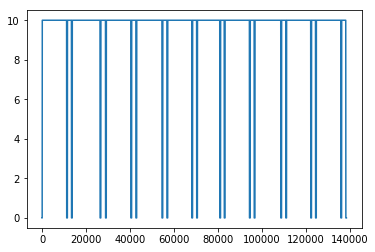

In [0]:
plt.plot(raw_output[:,0])
plt.show
# This should show the aforementioned alternating pattern

In [0]:
### Special case, for out61.txt and out73.txt datasets
# DO NOT EXECUTE OTHERWISE !
if RAW_OUTPUT_FILENAME == 'out61.txt' or RAW_OUTPUT_FILENAME == 'out73.txt':
  l = raw_output[:,0]
  K = -1
  for i in range(l.shape[0] - 2):
    if l[i-1] < 10 and l[i] == 10 and l[i+1] >= 2 and l[i+2] < 2:
      print(i)
      K = i
  if K >= 0:
    raw_output[K,0] = 0
    raw_output[K+1,0] = 0

111203


In [0]:
# Remove the starting garbage
moveIndex = find_first(10, raw_output[:,0])
raw_output = raw_output[moveIndex:]

In [0]:
trainingSetX = [0]*10
testingSetX = [0]*10
trainingSetY = [0]*10
testingSetY = [0]*10

for i in range(10):
  moveIndex = min(find_first(0, raw_output[:,0]), find_first(1, raw_output[:,0]))
  trainingSetX[i] = raw_output[:moveIndex,1:]
  trainingSetY[i] = i*np.ones((trainingSetX[i].shape[0],1))
  
  raw_output = raw_output[moveIndex:]
  moveIndex = find_first(10, raw_output[:,0])
  raw_output = raw_output[moveIndex:]
  
  moveIndex = min(find_first(0, raw_output[:,0]), find_first(1, raw_output[:,0]))
  testingSetX[i] = raw_output[:moveIndex,1:]
  testingSetY[i] = i*np.ones((testingSetX[i].shape[0],1))
  
  raw_output = raw_output[moveIndex:]
  moveIndex = find_first(10, raw_output[:,0])
  raw_output = raw_output[moveIndex:]

In [0]:
for label in range(10):
  print('Training {0}s: {1}'.format(label, trainingSetX[label].shape[0]))
  print('Testing {0}s: {1}'.format(label, testingSetX[label].shape[0]))

Training 0s: 11106
Testing 0s: 1838
Training 1s: 12642
Testing 1s: 2128
Training 2s: 11172
Testing 2s: 1936
Training 3s: 11497
Testing 3s: 1894
Training 4s: 10954
Testing 4s: 1842
Training 5s: 10165
Testing 5s: 1672
Training 6s: 11096
Testing 6s: 1797
Training 7s: 11747
Testing 7s: 1928
Training 8s: 10972
Testing 8s: 1827
Training 9s: 11154
Testing 9s: 1892


In [0]:
x_train = np.concatenate(trainingSetX)
y_train = np.concatenate(trainingSetY)
x_test = np.concatenate(testingSetX)
y_test = np.concatenate(testingSetY)

In [0]:
print('Training set input data: {}'.format(x_train.shape))
print('Training set labels: {}'.format(y_train.shape))
print('Testing set input data: {}'.format(x_test.shape))
print('Testing set labels: {}'.format(y_test.shape))

Training set input data: (112505, 72)
Training set labels: (112505, 1)
Testing set input data: (18754, 72)
Testing set labels: (18754, 1)


In [0]:
pickle.dump(((x_train, y_train),(x_test, y_test)),
            open(RAW_OUTPUT_FILENAME + '.pck', 'wb'))

# 2. Train 1 FC layer

## 2.1 Load data from pickled files

In [0]:
(x_train, y_train),(x_test, y_test) = pickle.load(
                                   open(RAW_OUTPUT_FILENAME + '.pck', 'rb'))

print('Training set input data: {}'.format(x_train.shape))
print('Training set labels: {}'.format(y_train.shape))
print('Testing set input data: {}'.format(x_test.shape))
print('Testing set labels: {}'.format(y_test.shape))

Training set input data: (112505, 72)
Training set labels: (112505, 1)
Testing set input data: (18754, 72)
Testing set labels: (18754, 1)


In [0]:
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)

## 2.2 Network and graph definition

In [0]:
def network_1fc(input):
  out = tf.layers.dense(input, 10, name='dense1')  
  return out

In [0]:
tf.reset_default_graph()

in_data_ph = tf.placeholder(tf.float32, [BATCH_SIZE,72])
gt_label_ph = tf.placeholder(tf.uint8)
out_label_op = network_1fc(in_data_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

lr_ph = tf.placeholder(tf.float32)
opt_op = tf.train.AdamOptimizer(learning_rate=lr_ph).minimize(loss_op)

## 2.3 Training

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(EPOCHS):
  if epoch < EPOCHS/2:
    lr_feed = LR
  else:
    lr_feed = LR/5
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = x_train[selected]
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_data_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  if epoch % 20 == 0:
    print('Epoch {} completed, average training loss is {}'.format(
            epoch+1, losses.mean()))
    test_accuracy()
test_accuracy()

Epoch 1 completed, average training loss is 6.933345697085063


KeyboardInterrupt: ignored

# 3. Train 2 FC layer

## 3.1 Load data from pickled files

In [0]:
(x_train, y_train),(x_test, y_test) = pickle.load(
                                   open(RAW_OUTPUT_FILENAME + '.pck', 'rb'))

print('Training set input data: {}'.format(x_train.shape))
print('Training set labels: {}'.format(y_train.shape))
print('Testing set input data: {}'.format(x_test.shape))
print('Testing set labels: {}'.format(y_test.shape))

Training set input data: (112521, 84)
Training set labels: (112521, 1)
Testing set input data: (18754, 84)
Testing set labels: (18754, 1)


In [0]:
############### RESTRICT TO FIRST 3 KERNELS

x_train = x_train[:,:36]
x_test = x_test[:,:36]


print('Training set input data: {}'.format(x_train.shape))
print('Training set labels: {}'.format(y_train.shape))
print('Testing set input data: {}'.format(x_test.shape))
print('Testing set labels: {}'.format(y_test.shape))


Training set input data: (112521, 36)
Training set labels: (112521, 1)
Testing set input data: (18754, 36)
Testing set labels: (18754, 1)


In [0]:
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)

## 3.2 Network and graph definition

In [0]:
def network_2fc(input):
  fc1 = tf.layers.dense(input, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(fc1, 10, name='dense2')  
  return out

In [0]:
tf.reset_default_graph()

in_data_ph = tf.placeholder(tf.float32, [BATCH_SIZE,36])
gt_label_ph = tf.placeholder(tf.uint8)
out_label_op = network_2fc(in_data_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

lr_ph = tf.placeholder(tf.float32)
opt_op = tf.train.AdamOptimizer(learning_rate=lr_ph).minimize(loss_op)

W0807 14:27:04.759977 140005153736576 deprecation.py:323] From <ipython-input-23-24a71349388f>:2: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0807 14:27:04.770270 140005153736576 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0807 14:27:08.046772 140005153736576 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops

## 3.3 Training

In [0]:
sess = tf.Session()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

"""
# Legacy training, providing 92.6% testing accuracy with AnalogNet data
for epoch in range(EPOCHS):
  if epoch < EPOCHS/2:
    lr_feed = LR
  else:
    lr_feed = LR/5
"""
"""
# Longer training -> 91.9% testing accuracy with 3-quantise-3 data
for epoch in range(EPOCHS*4):
  if epoch < EPOCHS:
    lr_feed = LR*4
  elif epoch < 2*EPOCHS:
    lr_feed = LR * 1.5
  elif epoch < 3*EPOCHS:
    lr_feed = LR / 2
  else:
    lr_feed = LR/5
"""
"""
# Even Longer training
for epoch in range(EPOCHS*10):
  if epoch < EPOCHS:
    lr_feed = LR*8
  elif epoch < 3*EPOCHS:
    lr_feed = LR * 4
  elif epoch < 6*EPOCHS:
    lr_feed = LR * 2
  elif epoch < 8:
    lr_feed = LR
  elif epoch < 9:
    lr_feed = LR / 2.
  else:
    lr_feed = LR / 5.
"""
max_test_accuracy = 0.
for epoch in range(EPOCHS*10):
  if epoch < EPOCHS:
    lr_feed = LR*8
  elif epoch < 3*EPOCHS:
    lr_feed = LR * 4
  elif epoch < 6*EPOCHS:
    lr_feed = LR * 2
  elif epoch < 8:
    lr_feed = LR
  elif epoch < 9:
    lr_feed = LR / 2.
  else:
    lr_feed = LR / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = x_train[selected]
    ys = y_train[selected, 0]
    
    _, current_loss = sess.run([opt_op, loss_op],
                       feed_dict={in_data_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy()
  
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, '2_fc/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  if epoch % 20 == 0:
    print('Epoch {} completed, average training loss is {}'.format(
            epoch+1, losses.mean()))
    print('Testing Acc.: {}'.format(current_test_accuracy))

# Restore best model
ckpt = tf.train.get_checkpoint_state('2_fc')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy(verbose=True)

Epoch 1 completed, average training loss is 1.9396354608866904
Testing Acc.: 0.8929066642125447


In [0]:
max_test_accuracy

0.9606400003433228

## 3.4 Extract weights, and manually run the FC layers (matrix operations, as on SCAMP5's microcontroller)

### 3.4.1 Weights extraction

In [0]:
#[n.name for n in tf.get_default_graph().as_graph_def().node]

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

In [0]:
fc1_k, fc1_b, fc2_k, fc2_b = sess.run([fc1_k, fc1_b, fc2_k, fc2_b])

In [0]:
pickle.dump((fc1_k, fc1_b, fc2_k, fc2_b),
            open(RAW_OUTPUT_FILENAME + '_trained_weights_2_fc.pck', 'wb'))

In [0]:
fc1_k, fc1_b, fc2_k, fc2_b = pickle.load(
    open(RAW_OUTPUT_FILENAME + '_trained_weights_2_fc.pck', 'rb'))

### 3.4.2 Compute accuracy when manually running the FC layers (matrix mult)

In [0]:
def forward_pass(inputVec):
  res1 = np.dot(inputVec, fc1_k) + fc1_b
  np.maximum(res1, 0, res1)
  res2 = np.dot(res1, fc2_k) + fc2_b
  return res2

In [0]:
l = np.array([9, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
print(forward_pass(l))
print(fc1_k)

[ -747816.  -221170.   553969. -1400164. -5069166.  3762788. -4552091.
  6160486.  -584692. -3187010.]
[[-254.  156.   34. ...  149.  -51.   78.]
 [ -88. -215.    1. ...  -46.  -17. -186.]
 [  63. -137. -240. ...  169.   24.  -99.]
 ...
 [  14.  418. -126. ...  174.   25. -448.]
 [-510.   75.  156. ...  532.  -13.  553.]
 [  92.  271.   29. ...   46.   28. -295.]]


In [0]:
correctPrediction = []
for (x, y) in zip(x_test, y_test):
  pred = np.argmax(forward_pass(x))
  correctPrediction.append(pred == y)

In [0]:
np.array(correctPrediction).mean()

0.9692864082910504

### 3.4.3 Round the weights and compute accuracy

In [0]:
PRECISION = 10000

In [0]:
fc1_k, fc1_b, fc2_k, fc2_b = fc1_k*PRECISION//1, fc1_b*PRECISION//1, fc2_k*PRECISION//1, fc2_b*PRECISION*PRECISION//1

In [0]:
correctPrediction = []
for (x, y) in zip(x_test, y_test):
  pred = np.argmax(forward_pass(x))
  correctPrediction.append(pred == y)

In [0]:
np.array(correctPrediction).mean()

0.9691784519054302

In [0]:
print(fc1_k.shape)

(32, 50)
